In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from dataprep.clean import clean_country

In [ ]:
# original site has a tool to query the data you want and it make the dataset more
# closer to what we need, so it would require 

In [6]:
csv_file_path = "./dataset/all/IHME-GDB-Deaths.csv"
df = pd.read_csv(csv_file_path)

In [27]:
df[df.location!="Global"]

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Deaths,Gabon,Both,80 to 84,Other neoplasms,Number,2016,0.592619,0.859968,0.357246
1,Deaths,Gabon,Male,85 plus,Other neoplasms,Number,2016,0.209733,0.344426,0.114420
2,Deaths,Gabon,Female,85 plus,Other neoplasms,Number,2016,0.243306,0.428627,0.103305
3,Deaths,Gabon,Both,85 plus,Other neoplasms,Number,2016,0.453039,0.659978,0.266404
4,Deaths,Gabon,Male,1 to 4,Cardiovascular diseases,Number,2016,1.307133,2.660127,0.520400
...,...,...,...,...,...,...,...,...,...,...
4886935,Deaths,Portugal,Both,75 to 79,Chronic respiratory diseases,Number,2016,837.307168,991.780932,727.360308
4886936,Deaths,Portugal,Male,80 to 84,Chronic respiratory diseases,Number,2016,816.673897,968.081178,688.748004
4886937,Deaths,Portugal,Female,80 to 84,Chronic respiratory diseases,Number,2016,582.763214,707.498930,429.973203
4886938,Deaths,Portugal,Both,80 to 84,Chronic respiratory diseases,Number,2016,1399.437111,1616.199266,1187.382977


In [30]:
cases_list = [
    "Cardiovascular diseases",
    "Chronic respiratory diseases",
    "Liver cancer due to other causes",
    "Larynx cancer",
    "Pancreatic cancer",
    "Colon and rectum cancer",
    "Tracheal, bronchus, and lung cancer",
    "Esophageal cancer",
    "Stomach cancer",
    "Congenital birth defects",
    "Hemoglobinopathies and hemolytic anemias",
    "Other neoplasms",
    "Neurological disorders",
    "Leukemia",
]


In [31]:
cdf=df[df.cause.isin(cases_list) & (df.location!="Global")]

In [ ]:
# let see which country suffer the most from this disease in recent years

In [35]:

total_by_country = cdf[cdf.sex=="Both"].groupby(["location"]).agg(
    {'val': 'sum',
    'upper': 'sum',
    'lower': 'sum'}
)
# .sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

In [36]:
total_by_country

,val,upper,lower
location,,,
Afghanistan,2.229134e+06,3.057791e+06,1.579217e+06
Albania,3.761616e+05,4.642947e+05,3.049161e+05
Algeria,2.662268e+06,3.403752e+06,2.080104e+06
Argentina,4.807245e+06,5.646202e+06,4.143166e+06
Armenia,5.368135e+05,6.046153e+05,4.776395e+05
...,...,...,...
Venezuela (Bolivarian Republic of),1.759395e+06,2.138333e+06,1.455079e+06
Viet Nam,7.932117e+06,1.023254e+07,5.873065e+06
Yemen,1.459667e+06,1.995187e+06,1.066636e+06


In [37]:

total_by_country = pd.DataFrame(total_by_country.to_records())
total_by_country.head()

,location,val,upper,lower
0,Afghanistan,2.229134e+06,3.057791e+06,1.579217e+06
1,Albania,3.761616e+05,4.642947e+05,3.049161e+05
2,Algeria,2.662268e+06,3.403752e+06,2.080104e+06
3,Argentina,4.807245e+06,5.646202e+06,4.143166e+06
4,Armenia,5.368135e+05,6.046153e+05,4.776395e+05


data from china, just to see what is the state of the one of the world largest oil consumer data looks like

In [21]:
china = cdf[(cdf.location=="China") & (cdf.sex=="Both")].groupby(['location', 'age']).agg(
    {'val': 'sum',
    'upper': 'sum',
    'lower': 'sum'}
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

In [22]:
china

val         upper         lower
location age                                               
China    1 to 4    8.568497e+04  1.004369e+05  7.086573e+04
         5 to 9    7.035211e+04  7.913335e+04  6.229497e+04
         10 to 14  6.412322e+04  7.177079e+04  5.739521e+04
         15 to 19  1.980993e+05  2.241450e+05  1.758901e+05
         20 to 24  3.308920e+05  3.752804e+05  2.920338e+05
         25 to 29  5.024035e+05  5.671066e+05  4.475828e+05
         30 to 34  8.541150e+05  9.605244e+05  7.633402e+05
         35 to 39  1.493004e+06  1.687635e+06  1.336967e+06
         40 to 44  2.760572e+06  3.109089e+06  2.462716e+06
         45 to 49  4.091288e+06  4.617934e+06  3.626145e+06
         50 to 54  6.136510e+06  6.917963e+06  5.455497e+06
         55 to 59  8.334466e+06  9.382199e+06  7.412606e+06
         60 to 64  1.213666e+07  1.359117e+07  1.088057e+07
         65 to 69  1.655626e+07  1.843283e+07  1.495299e+07
         70 to 74  2.310905e+07  2.566377e+07  2.104206e+07
         75 to 79  2.649286e+07  2.926884e+07  2.418939e+07
         80 to 84  2.638573e+07  2.908979e+07  2.379559e+07
         85 plus   2.483342e+07  2.733902e+07  2.181655e+07

In [23]:
# create lables for chart
x_axis_label = [i[1].replace(' to ', '-') for i in china.index]
print(x_axis_label)

['1-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 plus']


Text(0.5, 0, 'Age')

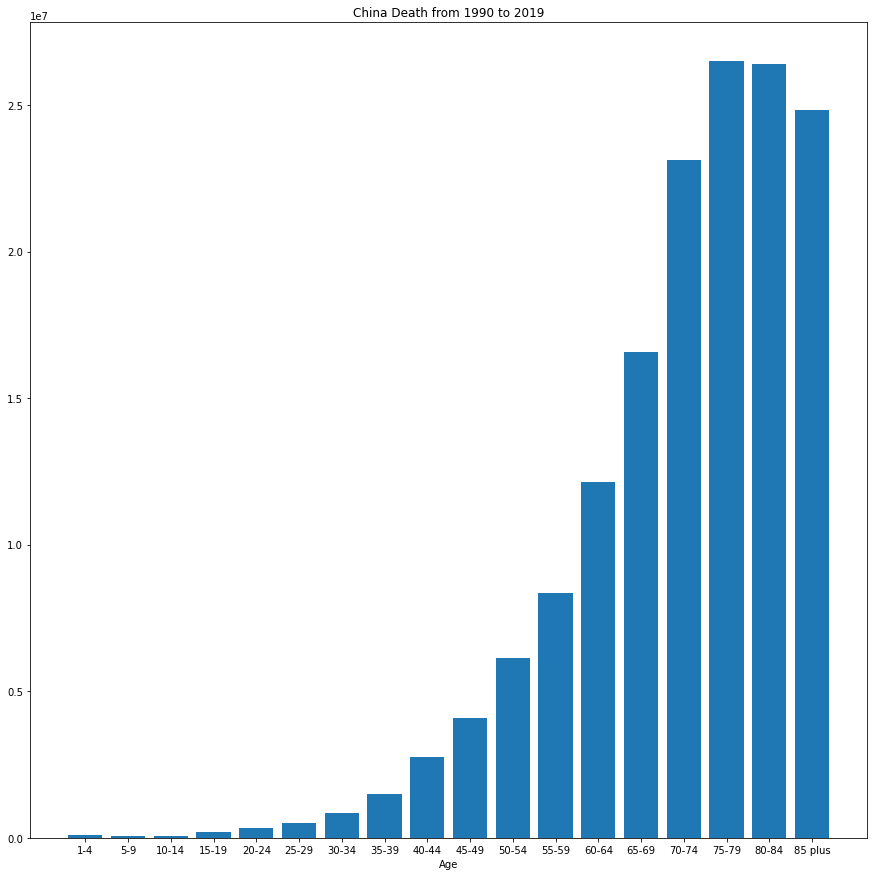

In [24]:
# plot for one country
fig, ax = plt.subplots(figsize=(15, 15))
ax.bar(x=x_axis_label, height=china.val.values)
ax.set_title("China Death from 1990 to 2019")
ax.set_xlabel("Age")

In [120]:
age_death_rate = cdf[cdf.sex=="Both"].groupby(['age']).agg(
    {'val': 'sum',
    'upper': 'sum',
    'lower': 'sum'}
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

In [121]:
age_death_rate

,val,upper,lower
age,,,
1 to 4,1.933874e+07,3.205634e+07,9.885945e+06
5 to 9,5.961514e+06,7.886582e+06,4.494648e+06
10 to 14,4.840440e+06,6.081593e+06,3.863349e+06
15 to 19,6.696293e+06,8.087553e+06,5.567580e+06
20 to 24,8.294902e+06,9.810588e+06,7.011984e+06
25 to 29,1.010276e+07,1.177444e+07,8.662754e+06
30 to 34,1.458002e+07,1.666662e+07,1.273829e+07
35 to 39,2.204464e+07,2.495255e+07,1.952333e+07
40 to 44,3.570944e+07,4.008026e+07,3.184056e+07


<BarContainer object of 18 artists>

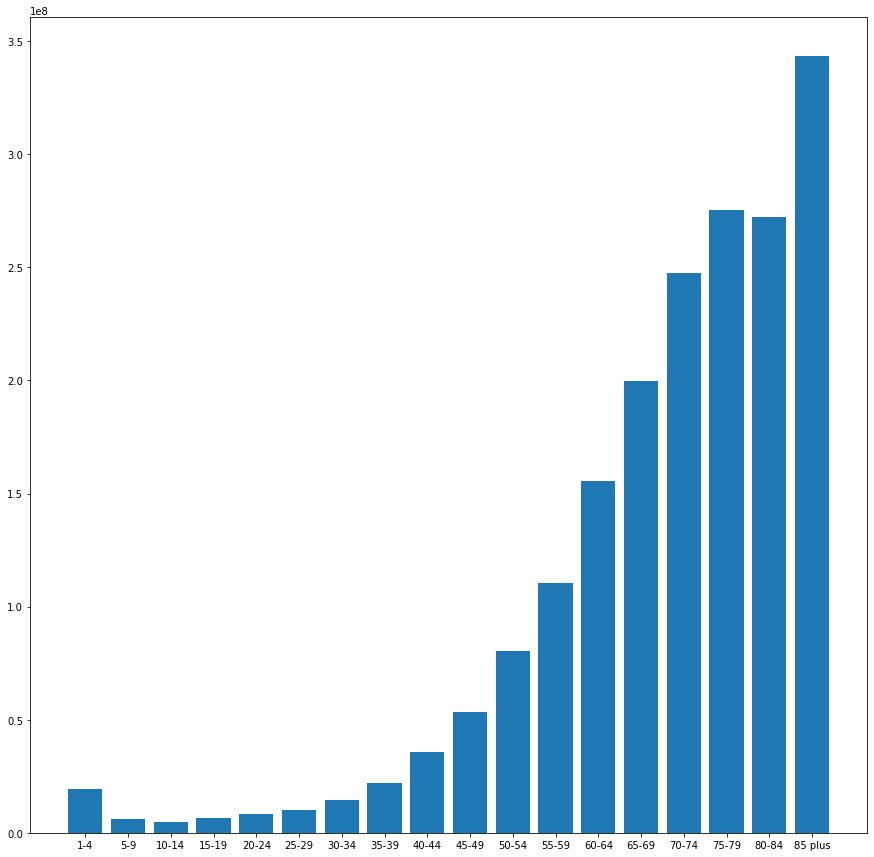

In [122]:
fig, ax = plt.subplots(figsize=(15, 15))
x_axis_label = [i[1].replace(' to ', '-') for i in china.index]
ax.bar(x=x_axis_label, height=age_death_rate.val.values)

In [34]:
cdf

,measure,location,sex,age,cause,metric,year,val,upper,lower
4,Deaths,Gabon,Male,1 to 4,Cardiovascular diseases,Number,2016,1.307133,2.660127,0.520400
5,Deaths,Gabon,Female,1 to 4,Cardiovascular diseases,Number,2016,0.506277,1.594778,0.177413
6,Deaths,Gabon,Both,1 to 4,Cardiovascular diseases,Number,2016,1.813410,4.013179,0.748420
7,Deaths,Gabon,Male,5 to 9,Cardiovascular diseases,Number,2016,0.883534,1.491956,0.494747
8,Deaths,Gabon,Female,5 to 9,Cardiovascular diseases,Number,2016,0.502440,0.915741,0.289085
...,...,...,...,...,...,...,...,...,...,...
4630423,Deaths,Argentina,Female,80 to 84,Stroke,Number,2006,2386.710574,2690.004918,2051.770217
4630424,Deaths,Argentina,Both,80 to 84,Stroke,Number,2006,4117.693988,4646.843314,3569.852176
4630425,Deaths,Argentina,Male,85 plus,Stroke,Number,2006,1701.973332,1915.251968,1449.030823
4630426,Deaths,Argentina,Female,85 plus,Stroke,Number,2006,3811.848856,4292.646199,3125.849003


In [35]:
each_year = cdf[cdf.sex=="Both"].groupby(['age', 'year', "location"]).agg(
    {'val': 'sum',
    'upper': 'sum',
    'lower': 'sum'}
).sort_values(by='age', key=lambda x: x.str.split(' ', expand=True)[0].astype('int'))

In [48]:
pd.DataFrame(each_year.to_records())

,age,year,location,val,upper,lower
0,1 to 4,1990,Afghanistan,123.802161,251.569842,45.748402
1,1 to 4,2010,Argentina,47.757941,59.538155,38.132899
2,1 to 4,2010,Algeria,112.904407,185.349133,63.360739
3,1 to 4,2010,Albania,18.931777,28.403113,10.330312
4,1 to 4,2010,Afghanistan,95.790463,186.120422,47.527911
...,...,...,...,...,...,...
85315,85 plus,1999,Viet Nam,35701.561231,42351.176110,28336.014076
85316,85 plus,1999,Venezuela (Bolivarian Republic of),7595.470933,8471.430913,6020.432246
85317,85 plus,1999,Uzbekistan,17370.999785,18259.860352,15613.066091
85318,85 plus,1999,United States of America,402665.507811,438028.946860,334826.310303


In [37]:
each_year.query("year==2019")

val         upper         lower
age     year location                                             
1 to 4  2019 Indonesia      212.012270    339.536022    149.955315
             India          969.902351   1313.288294    718.470924
             Hungary          1.380377      1.899329      0.874539
             Honduras        18.208949     34.032755      7.379660
             Haiti          211.209118    366.792208     79.631302
...                                ...           ...           ...
85 plus 2019 Algeria      32139.094540  36959.176300  27104.176321
             Albania       5382.987286   6600.857457   4160.189293
             Afghanistan   6636.642420   7847.148201   5045.227029
             Zambia        2359.632430   2837.981251   1855.141774
             Zimbabwe      2499.231806   3167.141289   1950.361929

[2844 rows x 3 columns]

ValueError: shape mismatch: objects cannot be broadcast to a single shape

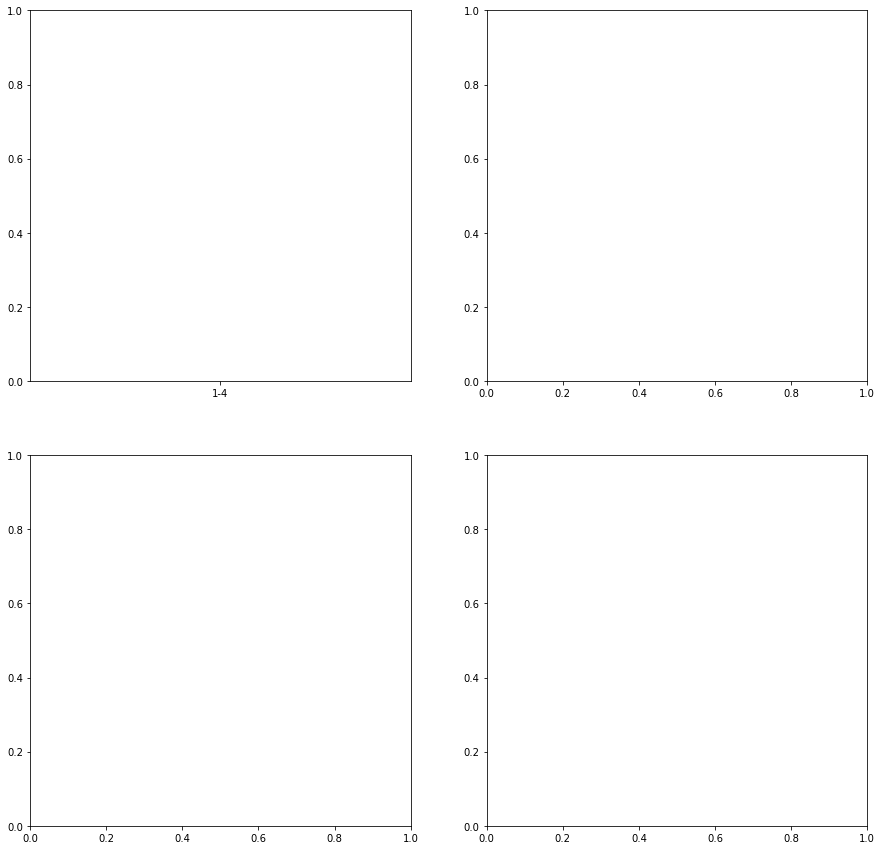

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for i in range(2):
    for j in range(2):
        axs[i, j].bar(x=x_axis_label, height=each_year.query(f"year==20{i:02d}").val.values)
# axs[1].bar(x=x_axis_label, height=each_year.query("year==2019").val.values)
plt.show()

2001


In [97]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)


In [14]:
total_by_country.head()

,location,val,upper,lower
0,Afghanistan,2.046121e+06,2.638194e+06,1.521819e+06
1,Albania,3.898698e+05,4.484619e+05,3.305901e+05
2,Algeria,2.666153e+06,3.250194e+06,2.146378e+06
3,Argentina,3.620805e+06,3.898845e+06,3.263956e+06
4,Armenia,4.838629e+05,5.152785e+05,4.461976e+05


In [51]:
# add country iso codes
total_by_country = clean_country(total_by_country, 'location', output_format='alpha-3')


  0%|          | 0/8 [00:00<?, ?it/s]

Country Cleaning Report:
	157 values cleaned (100.0%)
Result contains 157 (100.0%) values in the correct format and 0 null values (0.0%)


In [93]:
total_by_country.describe()

,val,upper,lower,nn
count,1.570000e+02,1.570000e+02,1.570000e+02,157.000000
mean,4.648683e+06,5.515382e+06,3.914767e+06,46.486824
std,1.735093e+07,2.009171e+07,1.486240e+07,173.509335
min,2.731631e+04,3.629686e+04,2.055393e+04,0.273160
25%,4.033722e+05,5.237928e+05,3.049161e+05,4.033720
50%,9.322235e+05,1.243332e+06,7.193531e+05,9.322230
75%,2.801925e+06,3.275085e+06,2.232634e+06,28.019250
max,1.877723e+08,2.182027e+08,1.602508e+08,1877.722510


In [ ]:
# i really like to do the geomap but plotly don't show the map color correctly
# so let do and scatter!

In [106]:
fig = px.choropleth(
    total_by_country,
    locations="location_clean",
    color="val",
    hover_name="location",
)
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
# plotly.offline.plot(fig,filename='world.html')
fig.show()
